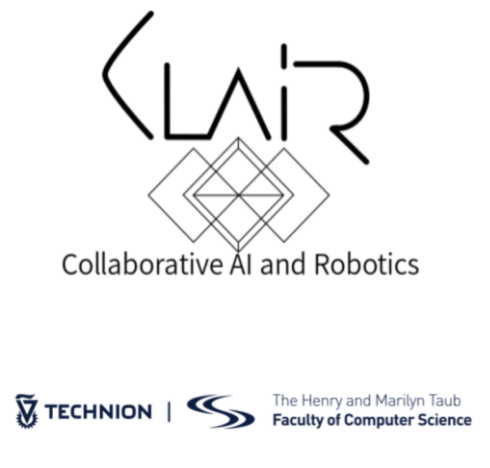

##Ido Jacobi, Shiran Peeran, Sarah Keren
####Based on Yuval Goshen, Guy Azran, Sarah Keren

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

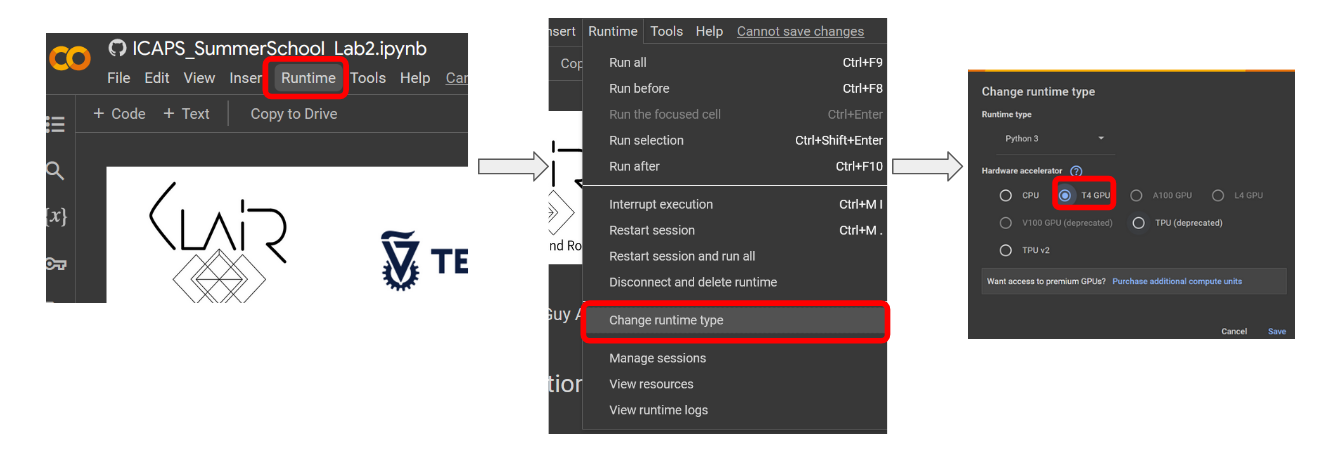

# Introduction to Motion Planning

In this tutorial, we will focus on **motion planning**, which deals with the low-level details of generating feasible motions that achieve the specified objectives safely and efficiently. For this, we will peel back some of the abstractions previously applied to our MTBW domain. By doing this, we aim to expose the underlying challenges that emerge and that need to be addressed when translating high-level plans to low-level motions and to understand some of the methodologies that can be used to address these challenges in real-world robotic settings.



It is important to note that, as we will see later on, even after we have both motion planning and task planning figured out, that does not mean we will be done. Another important aspect is that in the real world, things might fail in various ways, so we can't simply send commands and assume they will be executed. We need a way to monitor the execution of our actions and provide feedback on whether a high-level action was successfully performed. Also, if an action fails, we need to find the best way to recover. We will not cover all this in this tutorial, but it is important to keep this in mind as we start understanding the complexities of motion planning.

# Setup

#### Required Tutorial Packages

In [ ]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

#### MuJoCo Render Speed-up with GPU

**CHANGE TO GPU RUNTIME FOR FASTER RENDERING**

In [ ]:
import os
import subprocess
from sys import stderr

try:
  is_gpu = not bool(subprocess.run('nvidia-smi').returncode)
except FileNotFoundError as e:
  is_gpu = False
if is_gpu:
  # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
  # This is usually installed as part of an Nvidia driver package, but the Colab
  # kernel doesn't install its driver via APT, and as a result the ICD is missing.
  # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
  NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
  if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
      f.write("""{
      "file_format_version" : "1.0.0",
      "ICD" : {
          "library_path" : "libEGL_nvidia.so.0"
      }
  }
  """)
else:
  print(
    'Cannot communicate with GPU. '
    'Make sure you are using a GPU Colab runtime. '
    'Go to the Runtime menu and select Choose runtime type. '
    'You can also skip this and use CPU with slower rendering.',
    file=stderr)

#### Set OpenGL Rendering

**SKIP THIS CELL IF RUNNING ON APPLE SILICON**

In [ ]:
%env MUJOCO_GL=egl

#### Video Display Utilities

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

#### Imports

In [ ]:
import mediapy as media
import numpy as np
from numpy import pi

# Introduction to continuous N Table Blocks World (NTBW)


Up until now, we have treated actions in the NTBW domain, such as 'pick up block x' or 'put down block x on table y' as atomic operations. However, in real-life applications, a robot must physically move to a block's position to execute these actions. This movement needs to be as precise as possible, efficient, safe, and free from collisions.
Moreover, actual movement occurs in the physical world where states are no longer merely discrete symbols, but are rather represented using continuous variables.


In NTBW, the state includes a continuous variable representing the positions of blocks and the joint angles of the robot, requiring a more complex and accurate state representation to be used by the motion planning and execution components.

We begin by introducing our continuous NTBW domain and by examining how a state is represented in this environment.


In [ ]:
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()
print(state.keys())

In this simulation, similar to real-world conditions, we operate within a continuous space. The state of the system includes the positions of blocks in three-dimensional space, the states of the robot's joints, the state of the gripper, the grasped object, and geometry contact information.
Let's see how all of them look (except for the last one, which we will talk about in the next lab).

In [ ]:
_ = state.pop('geom_contact', None)
for key, value in state.items():
    print(key, ":", value)
    print()

## Workspace and Configuration Space

Two important concepts we need to know to better understand the state representation are the **workspace** and **configuration space**.


In the context of robotics, the workspace refers to the physical space in which a robot operates. This includes all the points in the robot's reach or the volume within which the end-effector or any part of the robot can move.


Configuration space, often abbreviated as C-space, represents all possible states or configurations of a robot, where each point in this space corresponds to a unique position and orientation of the robot. In C-space, obstacles are represented as regions that the robot's configuration cannot occupy.

The configuration space is multi-dimensional, depending on the number of **degrees of freedom (DOF)** of the robot, typically reprsenting its controllable joints. Thus, a **configuration** corresponds to a unique position and orientation of the robot.  



The image below, taken from MODERN ROBOTICS MECHANICS, PLANNING, AND CONTROL
Kevin M. Lynch and Frank C. Park https://hades.mech.northwestern.edu/images/7/7f/MR.pdf, demonstrates the idea of a configuration space of 3 different items.  


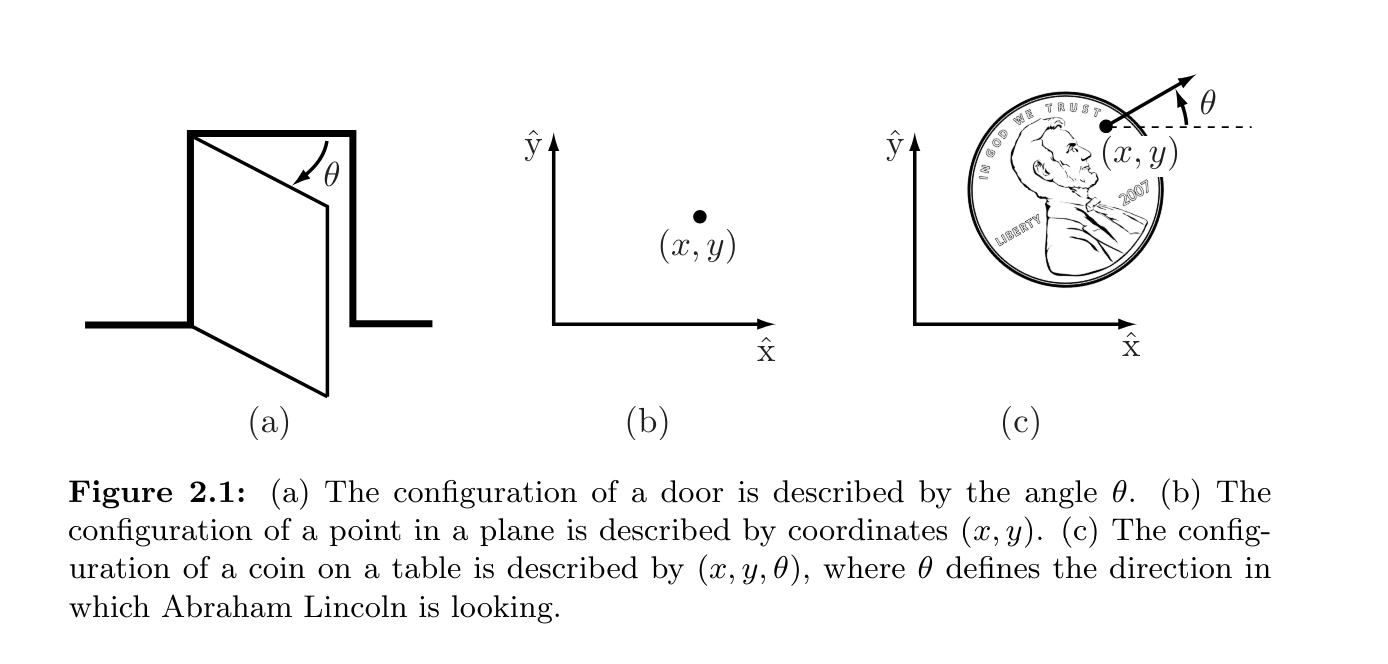





If you want to undestand this idea better, use this [link](https://www.cs.unc.edu/~jeffi/c-space/robot.xhtml). This easy-to-use online app, created by Prof. Ron Alterovitz's from UNC, will allow you to play around with a robotic arm with 2 DOF and see the mapping between workspace and C-Space.  

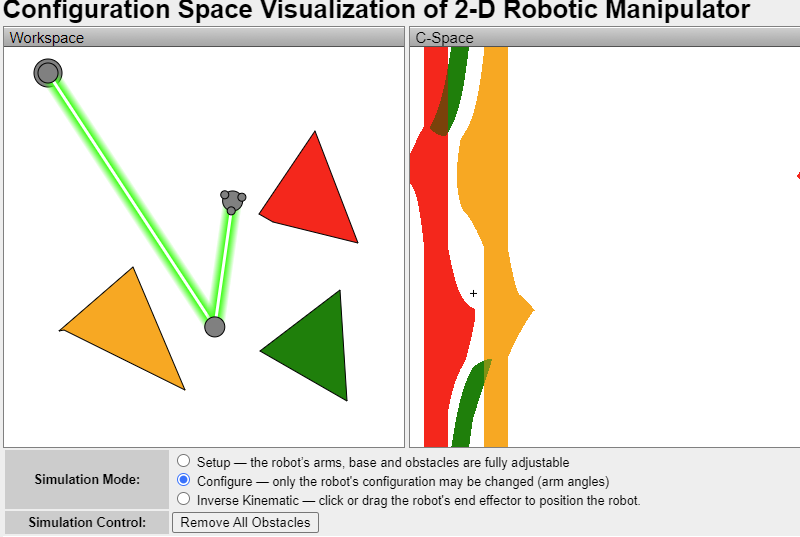

In summary, while the workspace is concerned with the physical limits of where a robot can operate, the configuration space deals with the abstract, mathematical representation of all possible states of the robot, crucial for path planning and avoiding collisions.

For our robotic arm, the workspace would be the volume of space around the base within which the arm can position its end-effector.

It's configuration space space has $6$ DOFs for each of its joints.


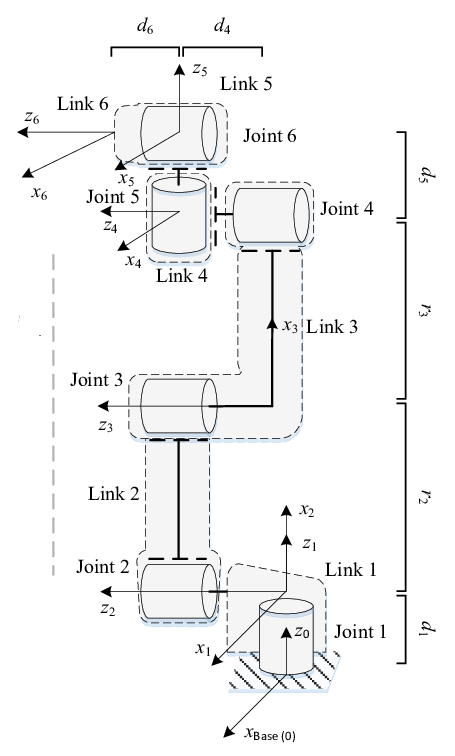

 Let's examine an image rendered from this environment to better visualize these elements.

In [ ]:
im = env.render()
media.show_image(im)

# Actions in Our Simulated Setting

In our simulated environment, actions consist of position control commands to the robot, specifying the desired configuration, i.e., the desired joint angles. The robot's actuators exert forces proportional to the difference between the target configuration (specified by the joint angles) and the current configuration. If we maintain the same target position across multiple simulation steps, the robot will gradually approach and stabilize near that position.

To achieve this, the robot relies on underlying controllers that manage the forces applied to reach the desired configuration. Typically, these controllers are PID (Proportional, Integral, and Derivative) controllers or controllers that employ more advanced methods such as feed-forward control. These controllers add another level of abstraction, and in some cases, integrating them with task and motion planning can be beneficial. However, we will not delve into these integration scenarios in this lab.

By understanding these control mechanisms, we can appreciate the complexities involved in precise robot movements and the importance of accurate position control in executing tasks.

**Note the difference from the way we used actions in task planning as instantaneous! Here, we need to make sure to apply the action for enough time to make sure the target configuration is reached!**

 Let's move the robot between different configurations and record a video of its movements to observe this behavior in action.

In [ ]:
number_of_steps = 100

In [ ]:
framerate = 60
frames = []

state = env.reset()

# move to all joints at -45 degrees, for number_of_steps steps:
action = [-pi/4]*6
for i in range(number_of_steps):
    state = env.step(action)
    frames.append(env.render())

# move to another config for number_of_steps steps:
action = [0, -pi/2, pi/2, 0, 0, 0]
for i in range(number_of_steps):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

Note that the last cell took a while to run, primarily because the env.render() call, which generates images from the environment, is time-consuming. To reduce runtime, from now on, let's render the environment only every 8 steps instead of after every single step. The videos will look a bit choppier, but we can adjust this setting whenever we need smoother, better-looking videos.

⚒ **Task 1**: Try setting different values to number_of_steps and rerun the code to see what happens.



Below, we implement a convenience function that moves the robot to a desired configuration. This function eliminates the need to rewrite the control loop each time. It is designed to automatically stop when the robot reaches the desired configuration and when the joint velocities are sufficiently low. Additionally, this method generates frames for a video at a specified frequency, allowing for flexible visualization of the robot's movement.

In [ ]:
def move_to(env, target_config, tolerance=0.05, end_vel=0.1, max_steps=None,
            render_freq=8):
    '''
    move robot joints to target config, until it is close within tolerance,
    or max_steps exceeded.
    @param target_joint_pos: position to move to
    @param tolerance: distance withing configuration space to target to consider
     as reached
    @param max_steps: maximum steps to take before stopping, no limit if None
    @param render_freq: how often to render and append a frame
    @return: success, frames
    '''
    joint_positions = env.robot_joint_pos
    joint_velocities = env.robot_joint_velocities

    frames = []

    i = 0
    while np.linalg.norm(joint_positions - target_config) > tolerance \
    or np.linalg.norm(joint_velocities) > end_vel:
        if max_steps is not None and i > max_steps:
            return False, frames

        state = env.step(target_config)
        joint_positions = state['robot_joint_pos']
        joint_velocities = state['robot_joint_velocities']

        if i % render_freq == 0:
            frames.append(env.render())

        i += 1

    return True, frames

And let's test it:

In [ ]:
framerate = 8
render_freq = 8

env.reset()

config1 = [-pi/4]*6
success, frames1 = move_to(env, config1)

config2 = [0, -pi/2, pi/2, 0, 0, 0]
success, frames2 = move_to(env, config2)

frames = np.concatenate([frames1, frames2])

# show video:
media.show_video(frames, fps=framerate)

⚒ **Task 2**:
Recall that our task is to pick up and move the blocks.
Try to move the end effector of the robotic arm to be above the yellow block that is on the right table while the end effector is facing downwards.
Complete the code in the following cell.
Give it 3-5 attempts to get as close as you can (you can find a proposed solution below).

In [ ]:
# remove this line before running the cell:
%%script false --no-raise-error


# choose a config that will bring the end effector to be above the yellow
# block that is on the right table. This configuration will be used as an action
above_right_yellow_block = # TODO - your code here

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

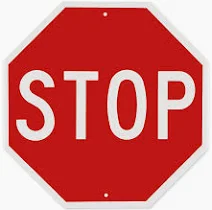

Below we give a possible solution. Don't let us spoil your fun.


In [ ]:
# proposed solution:
above_right_yellow_block = [-0.6, -0.6, 1.7, 0.7, pi/2, 0]

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

# Forward and Inverse Kinematics

In the previous task, we aimed to position the end effector of the robot directly above the yellow block. The robot is controlled in configuration space, which involves specifying joint angles. However, our objective is to place the end effector at specific coordinates and orientation within the workspace—the physical space where the robot interacts with objects. This task requires converting our workspace goal (position and orientation of the end effector) into the appropriate joint configurations in the configuration space.

![forward and inverse kinematic](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/assets/figures/f_inv_kinematics.png?raw=true)

The process of mapping from a robot's configuration—specifically its joint angles—to the workspace—where the end effector's position and orientation are defined—is known as **forward kinematics**. This mapping is indeed feasible and relatively intuitive if we know the robot's geometric parameters, such as the lengths and relative positions of its links. The computation of the end effector's pose from the joint configurations is typically represented using matrix multiplications. These matrices, often referred to as transformation matrices, sequentially transform the pose from one joint to the next along the robot's arm, ultimately resulting in the pose of the end effector in the workspace.

**Inverse kinematics (IK)** involves determining the joint configurations that will achieve a specified position and orientation of the end effector in the workspace. This process is the reverse of forward kinematics and can be more complex because there may be multiple, or even an infinite number of, joint configurations that can result in the same end effector pose. IK essentially frames this challenge as an optimization problem, where the goal is to find the best set of joint angles that satisfy the end effector's target position and orientation. Unlike the direct calculations used in forward kinematics, solving inverse kinematics often requires the use of numerical methods and optimization techniques to find feasible solutions.

In this lab, we won't delve into the detailed mathematical formulations typically required to solve inverse kinematics. Instead, we'll utilize an out-of-the-box implementation that simplifies this process. This approach allows us to focus more on the application and integration of inverse kinematics within our tasks, without getting caught up in the complexities of the underlying algorithms.

# PickUp in the real(alistic) world

Having explored the continuous space representation, we move on to demonstrate how an action, considered atomic in the task planning domain, is implemented in our robotic setting.

A first thing to consider if we want to pick up an object, is reaching a configuration from which it can be picked up.

If we want to pick up the yello block, we need to first extract the Cartesian coordinates of its position and set a target position for the robot's end effector to be 10 centimeters above the block. This height will allow the robot to grasp the block effectively.

In [ ]:
object_positions = state['object_positions']
target_position = object_positions['block 2']
target_position[2] += 0.1  # add 10 centimeters to Z axis
print("target position:", target_position)

We also need to specify the target orientation for the end effector. For picking up blocks, the end effector should be oriented downward. This target orientation can be provided as a rotation matrix, which will define the exact angular positioning required for the end effector to successfully engage with the blocks.

In [ ]:
facing_down_R = [[0, 0, -1],
                 [0, 1, 0],
                 [1, 0, 0]]

## `move-to-position` with inverse kinematics

To make things simpler, we provide a motion planning utility class that includes the implementation of inverse kinematics, among other useful methods that will be detailed later. Let's utilize this class to find an inverse kinematic solution where the end effector is oriented downwards and positioned directly above the yellow block.

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner

motion_planner = NTableBlocksWorldMotionPlanner()
above_yellow_block_config = motion_planner.ik_solve(goal_pos=target_position,
                                                    goal_R=facing_down_R,)
print(above_yellow_block_config)


Let's test this solution:

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)
media.show_video(frames, fps=framerate)

## Moving in Configuration Space

Now that we can easily find inverse kinematics solutions for pickup and drop-off positions, let's try to pick up the yellow block and place it above the purple block, which is on the left table. To do this, we:

1. Move above the yellow block (which we have already done).
2. Close the gripper* by calling env.set_gripper(True). This sets the gripper's state to closed, enabling it to grasp any nearby object.
3. Use inverse kinematics to compute the configuration above the purple block, similar to what we did before.
4. Open the gripper using env.set_gripper(False) to release the yellow block.



*here, we are using a suction gripper, for which close and open refer to creating and releasing suction using a vacuum system.

This process is quite straightforward. Nothing should go wrong, right?

⚒ **Task 3**:
complete the code cell where decribed below to perform what we discussed above.

In [ ]:
# remove this line before running the cell:
%%script false --no-raise-error

drop_position = object_positions['block 8']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = ### complete here! use the move_to function ###
env.set_gripper(False)

media.show_video(frames, fps=framerate)


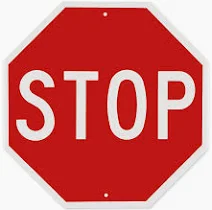

Below we give a possible solution. Don't let us spoil your fun.


In [ ]:
drop_position = object_positions['block 8']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = move_to(env, above_purple_block_config, max_steps=100)
env.set_gripper(False)

media.show_video(frames, fps=framerate)


We successfully identified a valid inverse kinematic solution for the drop-off position and attempted to move to it from our pick-up configuration. However, during this transition, the robot collided with an obstacle (here, it's base). The issue arises because the robot, while moving in the configuration space, follows the shortest path, which corresponds to a straight line.


It's important to note that this 'straight line' in the configuration space does not translate to a straight line in the workspace. This discrepancy can lead to unexpected collisions because the path in the workspace might intersect with obstacles that are not accounted for in the configuration space. This incident underscores the importance of **motion planning**, which helps ensure that a robot's path is both collision-free and feasible within the physical workspace.